In [1]:
# =============================================================================
# Import Libraries and functions
from Data_preparation import data_processing_with_BH_scaled
import numpy as np
import torch
import gpytorch
from gpytorch.means.mean import Mean
from torch import Tensor
import os
import matplotlib.pyplot as plt
from gpytorch.kernels.keops import MaternKernel
from gpytorch.kernels import ScaleKernel, ProductKernel
import tqdm
import cloudpickle
from glob import glob
from scipy.stats import entropy
from torch.optim import Adam
from matplotlib.ticker import AutoMinorLocator
from gpytorch.likelihoods.gaussian_likelihood import (
    FixedNoiseGaussianLikelihood)
from botorch.models.utils.inducing_point_allocators import (GreedyVarianceReduction, InducingPointAllocator)
# =============================================================================
cwd = os.getcwd()
plots_folder = cwd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32 
# =============================================================================
plots_folder = glob("..\\Plots\\")[0]
pickles_folder = glob("..\\Pickles\\")[0]

def Pickle_file(folder, filename, data):
    with open(folder + filename + '.pkl', mode='wb') as file:
        cloudpickle.dump(data, file)
        
def Unpickle_file(folder,filename):
    with open(folder+ filename + '.pkl', mode='rb') as file:
        data = cloudpickle.load(file)
    return data

plt.rcParams.update({'font.family':'sans','font.size': 7,
                     'font.weight':'regular','mathtext.default':'regular',
                    'legend.fontsize':7})   

# Load dataset - Data preparation
#### 1. Load data <small>(contains some hardcoding; CPT and BH data were organized together in an incomplete (containing nans) dataset (this is not neccessary was done to be used to another project).</small>
#### 2. split train/test data
#### 3. Standardize CPT data (lognormal distribution assumption)
#### 4. Prepare borehole data - Dir. based transformation

In [2]:
dis_depth = 185                 # we disregard the upper 1.86m due to unstable cpt measurements
num_vertical_des_points = 438   # number of points that define the depth incerement for the training data
num_cpts_w_bhs = 30             # number of CPTs and boreholes (containing at least 1 measurement)
bh_ids = [0, 1, 12, 21, 27] # the indices of boreholes in the dataset (see dataframe) 
num_bhs = 5                 # number of training BHs


# The soundings are re-aranged in the data preparation step: we sort the soundings according to the x-distance from the origin (so we keep -manually- some indices here)
data_qc, xt, yt, zt, grid, \
    z_mat, mapping, Dxy, Dz, depth_0 = data_processing_with_BH_scaled(
        num_cpts_w_bhs, num_bhs, 
        dis_depth, 
        num_vertical_des_points,
        "qc")
    
data_fs, _, _, _, \
    _, _, _, _, _, _ = data_processing_with_BH_scaled(
        num_cpts_w_bhs, num_bhs, 
        dis_depth, 
        num_vertical_des_points,
        "fs")    

ids = [i for i in range(data_qc.shape[1])]
cpt_ids = [i for i in ids if i not in bh_ids]

# logarithmic transform to the CPT data
data_qc[:, [i for i in ids if i not in bh_ids]] = np.log(data_qc[:, 
                                                           [i for i in ids if
                                                            i not in bh_ids]])   

data_fs[:, [i for i in ids if i not in bh_ids]] = np.log(data_fs[:, 
                                                           [i for i in ids if
                                                            i not in bh_ids]])   

C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\3810585617.py:31: RuntimeWarning: invalid value encountered in log
  data_fs[:, [i for i in ids if i not in bh_ids]] = np.log(data_fs[:,


In [3]:
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()

cpt_test_ids = [8, 16, 20, 24, 28]      # the selected (randomly) test CPTs
excl_ids =     [2, 13, 25, 26, 28]          # we exclude some very shallow CPTs from training dataset (defined in a pre-analysis step)

data_qc_test = data_qc[:, cpt_test_ids]
data_fs_test = data_fs[:, cpt_test_ids]

data_qc  = data_qc[:, [i for i in ids if i not in cpt_test_ids+excl_ids]]
data_fs  = data_fs[:, [i for i in ids if i not in cpt_test_ids+excl_ids]]


xt_test = xt[cpt_test_ids]
yt_test = yt[cpt_test_ids]

grid[1] = grid[1][[i for i in ids if i not in cpt_test_ids+excl_ids]]
grid[2] = grid[2][[i for i in ids if i not in cpt_test_ids+excl_ids]]

# -----------------------------------------------------------------------------
ids = [i for i in range(data_qc.shape[1])]
bh_ids = [0, 1, 10, 16, 19]    # the indices of borehole data in the updated dataset
cpt_ids = [i for i in ids if i not in bh_ids]  # the indices of cpt data in the updated dataset

In [4]:
data_bhs = data_qc[:, bh_ids]
y_nonnan_bhs = data_bhs.T.ravel()
y_nonnan_bhs = y_nonnan_bhs[~np.isnan(y_nonnan_bhs)]
len_nonnan_bhs = len(y_nonnan_bhs)
train_x_bhs = torch.zeros((len_nonnan_bhs, 3), dtype = dtype)
rowind = 0;
for i, dat in enumerate(data_bhs.T):
    idni = len(dat[~np.isnan(dat)])
    idni = len(dat[~np.isnan(dat)])
    train_x_bhs[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_bhs[rowind:rowind+idni, 1] = grid[1][bh_ids[i]]
    train_x_bhs[rowind:rowind+idni, 2] = grid[2][bh_ids[i]]
    rowind +=idni

data_qc[data_qc == -np.inf] = np.nan
data_fs[data_fs == -np.inf] = np.nan
data_qc = data_qc[:, cpt_ids]
data_fs = data_fs[:, cpt_ids]


idnan = np.isnan(data_fs).T.ravel()
id_nonnan_qc = ~np.isnan(data_qc.T.ravel())
id_nonnan_fs = ~np.isnan(data_fs.T.ravel())

y_nonnan_qc = data_qc.T.ravel()
y_nonnan_qc = y_nonnan_qc[id_nonnan_fs]

y_nonnan_fs = data_fs.T.ravel()
y_nonnan_fs = y_nonnan_fs[id_nonnan_fs]

len_nonnan_cpts = len(y_nonnan_qc)
# create the train_x for cpts
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()

train_x_cpts = torch.zeros((len_nonnan_cpts, 3), dtype = dtype)
rowind = 0; 
for i, dat in enumerate(data_fs.T):
    idni = len(dat[~np.isnan(dat)])
    train_x_cpts[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_cpts[rowind:rowind+idni, 1] = grid[1][cpt_ids[i]]
    train_x_cpts[rowind:rowind+idni, 2] = grid[2][cpt_ids[i]]
    rowind +=idni

In [5]:
# Standardize data (lognormal dist assumption)

mu_qc = np.mean(np.exp(y_nonnan_qc))
std_qc = np.std(np.exp(y_nonnan_qc))
mu_fs = np.mean(np.exp(y_nonnan_fs))
std_fs = np.std(np.exp(y_nonnan_fs))

def pars_log(mu_x,std_x):
    std_x_log = np.sqrt(np.log(std_x**2/mu_x**2 +1))
    mu_x_log = np.log(mu_x)-(std_x_log**2)/2    
    return mu_x_log,std_x_log

mu_qc_log, std_qc_log = pars_log(mu_qc, std_qc) 
mu_fs_log, std_fs_log = pars_log(mu_fs, std_fs) 

# data_cpts_stdzd = (data_cpts - mu_cpt_log) / std_cpt_log
data_qc_stdzd = (y_nonnan_qc.reshape(-1, 1) - mu_qc_log) / std_qc_log
data_fs_stdzd = (y_nonnan_fs.reshape(-1, 1) - mu_fs_log) / std_fs_log

In [6]:
# Prepare borehole data
y = data_bhs.copy().T.ravel()
y = y[~np.isnan(y)]
y_vec = y.astype(int)
y_discrete = torch.tensor(y_vec).long()
classes = np.unique(y_vec)
num_classes = len(classes)
Y = np.zeros((len(y_vec), len(classes)))
for i, e in enumerate(y_vec):
    # print(i, e)
    Y[i, np.where(classes == e)[0]] = 1
    
# label transformation
a_eps = 0.002    # choose a value for \alpha_{eps}
s2_tilde = np.log(1.0 / (Y + a_eps) + 1)
Y_tilde = np.log(Y + a_eps) - 0.5 * s2_tilde

In [7]:
# concatenate the data and the data noise variances
train_y = torch.cat([torch.tensor(Y_tilde).mT.ravel(), 
                       torch.tensor(data_qc_stdzd).ravel(), 
                       torch.tensor(data_fs_stdzd).ravel()], -1)

mean_ytilde = np.mean(Y_tilde)
std_Y_tilde = np.std(Y_tilde)

train_Yvar_bhs = torch.tensor(s2_tilde).mT.ravel().unsqueeze(-1)
train_Yvar_qc = torch.ones_like(torch.tensor(data_qc_stdzd)) * torch.tensor(1e-5) 
train_Yvar_fs = torch.ones_like(torch.tensor(data_fs_stdzd)) * torch.tensor(1e-5) 
train_Yvar = torch.cat([train_Yvar_bhs, train_Yvar_qc, train_Yvar_fs])

In [8]:
# create the train_x full with index 
num_tasks = num_classes + 2
i_ind = torch.zeros(train_x_bhs.shape[0], num_tasks)
for i in range(num_tasks):
    i_ind[:, i] = torch.ones(train_x_bhs.shape[0]) * i
    
i_ind_qc = torch.ones(train_x_cpts.shape[0])*int(num_classes)
i_ind_fs = torch.ones(train_x_cpts.shape[0])*int(num_classes + 1)
# ------------------------------------------------------------------------------
train_Xf = torch.cat([
     torch.cat([train_x_bhs, i_ind[:, 0].view(-1,1)], -1), 
     torch.cat([train_x_bhs, i_ind[:, 1].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 2].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 3].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 4].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 5].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 6].view(-1,1)], -1),
     torch.cat([train_x_cpts, i_ind_qc.view(-1,1)], -1),
     torch.cat([train_x_cpts, i_ind_fs.view(-1,1)], -1)
 ], 0)

train_Xbhs = torch.cat([torch.cat([train_x_bhs, i_ind[:, i].view(-1,1)], -1) for i in range(num_classes)])
train_x_bhsn = train_Xbhs[:,:-1]

train_Xf = train_Xf.type(dtype=dtype)
train_i = train_Xf[:, -1].long()
train_X = train_Xf[:,:-1].type(dtype).detach()

train_Y = train_y.unsqueeze(-1)
train_yvar = train_Yvar

# Construct the model
### 1. Initialize inducing points from existing CPTs and BHs locations
### 2. define the LMC-based GP model

In [9]:
# We'll learn 1500 inducing points for each process
# Here just to initialize the model (not used afterwards)
num = 1500

inducing_points1 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num]]
inducing_points2 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num]]
inducing_points3 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num]]
inducing_points4 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num]]
inducing_points5 = train_x_cpts[torch.randperm(train_x_cpts.size(0))[:num]]
inducing_points6 = train_x_cpts[torch.randperm(train_x_cpts.size(0))[:num]]

inducing_points = torch.cat([inducing_points1.unsqueeze(0), inducing_points2.unsqueeze(0), 
                            inducing_points3.unsqueeze(0), inducing_points4.unsqueeze(0), 
                            inducing_points5.unsqueeze(0),inducing_points6.unsqueeze(0)], dim = 0).to(dtype).to(device)

In [10]:
# Use the botorch function to find some appropriate inducing points for initialization

inducing_point_allocator = GreedyVarianceReduction()
def init_inducing_points(
        inputs: Tensor,
    ) -> Tensor:
        r"""
        Reinitialize the inducing point locations in-place with the current kernel
        applied to `inputs` through the model's inducing point allocation strategy.
        The variational distribution and variational strategy caches are reset.

        Args:
            inputs: (\*batch_shape, n, d)-dim input data tensor.

        Returns:
            (\*batch_shape, m, d)-dim tensor of selected inducing point locations.
        """
        var_strat = model.variational_strategy
        var_strat = var_strat.base_variational_strategy
        with torch.no_grad():
            num_inducing = var_strat.inducing_points.size(-2)
            inducing_points = inducing_point_allocator.allocate_inducing_points(
                inputs=inputs,
                covar_module=model.covar_module,
                num_inducing=num_inducing,
                input_batch_shape=torch.Size([num_latents]),
            )
            var_strat.inducing_points.copy_(inducing_points)
            var_strat.variational_params_initialized.fill_(0)

        return inducing_points

In [11]:
# Build the model
num_latents = 6

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, likelihood):

        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )
        super(MultitaskGPModel, self).__init__(variational_strategy)
        self.likelihood = likelihood
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = ScaleKernel(ProductKernel(MaternKernel(nu=0.5,active_dims=torch.tensor([0]),
                                                                    batch_shape=torch.Size([num_latents])),               
                                    MaternKernel(nu=0.5, active_dims=torch.tensor([1, 2]),
                                                  batch_shape=torch.Size([num_latents]))),
                                        batch_shape=torch.Size([num_latents]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [12]:
# call the model and initialize hyperparameters
likelihood  = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1))

model = MultitaskGPModel(inducing_points = inducing_points, likelihood = likelihood)
# ini_inducing_points = init_inducing_points(train_X)
# model = MultitaskGPModel(inducing_points = ini_inducing_points, likelihood = likelihood)

model.covar_module.base_kernel.kernels[0].lengthscale = torch.tensor([0.0271], dtype = dtype, device = device)  #ini
model.covar_module.base_kernel.kernels[1].lengthscale = torch.tensor([0.15], dtype = dtype, device = device)

train_X, train_y, train_i = train_X.to(device).contiguous(), train_y.to(device).contiguous(), train_i.to(device).contiguous()
train_yvar = train_yvar.to(device).contiguous()
model = model.to(device)
model.likelihood = model.likelihood.to(device)

## Training (mini-batch)

In [13]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_X, train_i, train_y, train_yvar)
train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)

In [ ]:
# Train the model in batches
hyperparameter_optimizer  = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.001)

model.train()
model.likelihood.train()

#-------------------------------------------------------------------------------------------------------------------
# the implemented objective function (Jankowiak, et al. 2020)
mll = lambda noise: gpytorch.mlls.PredictiveLogLikelihood(FixedNoiseGaussianLikelihood(noise=noise.squeeze(-1)),
                                                             model, num_data=train_y.numel())
#-------------------------------------------------------------------------------------------------------------------
num_epochs = 200
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    
    for x_batch, i_batch, y_batch, y_var_batch in minibatch_iter:

        hyperparameter_optimizer.zero_grad()
        output = model(x_batch, task_indices = i_batch)

        loss = -mll(y_var_batch)(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        hyperparameter_optimizer.step()

In [17]:
#torch.save(model.state_dict(), 'VLMC_CPT_qc-fs-uscs_rescaled.pth') # save a trained model

### Load a pre-trained model

In [13]:
#state_dict = torch.load('6lat_LMCvar_qcfsbh_438v_250it_5000b_aeps002_lr_Delta_const_trend_paper_loo.pth')
state_dict = torch.load('VLMC_CPT_qc-fs-uscs.pth')

likelihood  = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1))
model = MultitaskGPModel(inducing_points = inducing_points, likelihood = likelihood)
model.load_state_dict(state_dict)
train_X, train_y, train_i = train_X.to(device).contiguous(), train_y.to(device).contiguous(), train_i.to(device).contiguous()
train_yvar = train_yvar.to(device).contiguous()
model = model.to(device)
likelihood = likelihood.to(device)

In [18]:
arr = model.variational_strategy.lmc_coefficients.cpu().detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
print(arr)

[[0.4275 1.2623 2.4111 2.4997 -0.4692 1.8523 1.3483 -0.0548 0.3782]
 [-0.2327 0.7075 -0.8164 -0.8533 -3.3130 0.6531 -2.0625 -0.3863 -0.0594]
 [-2.8224 2.9309 -0.5710 -0.7311 0.3729 -2.7305 0.5235 -0.0557 -0.1031]
 [-0.5994 1.4421 -0.3639 -0.4080 1.9473 2.0547 -3.3195 0.0732 0.0796]
 [2.3843 0.3698 0.3829 0.3824 1.2213 -0.9117 -0.1879 -1.0349 -1.0479]
 [-2.5291 -1.5994 0.7430 1.0503 0.5360 -0.9599 -1.7791 -0.4390 0.3191]]


from IPython.display import Image
![title](site_plan.png)

In [19]:
# Predictions (at verification boreholes)
Dz = np.max(z_mat) 

nz = len(z_mat)


# xcoords (BH_9,BH_1,H_5,BH_3) = [55.7300 104.2000 149.7200 192.4700] m
# ycoords (BH_9,BH_1,H_5,BH_3) = [16.1100 71.5800 21.6400 70.8200] m


x_p_m = np.array([0.27609611, 0.51622492, 0.74173892, 0.95352985])       # the scaled (divided by Dx) locations of the verification boreholes 
y_p_m = np.array([0.07981174, 0.35461977, 0.10720832, 0.35085459])       # the scaled (divided by Dx) locations of the verification boreholes 


nv_test = nz - int(1.86/0.01) + 1    # dis_depth = 1.86m from top
nh_test = (x_p_m).shape[0]
n_uscs_samples = 400

z_t = np.linspace(0.00, np.max(grid[0].numpy()), nv_test)
z_t = np.linspace(0.00, 1, nv_test)

x_t = x_p_m
y_t = y_p_m

n_v = (z_t).shape[0]
n_h = (x_t).shape[0]

N = n_v * n_h


grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).squeeze().t().to(train_X)

In [20]:
test_dataset = TensorDataset(test_x, test_x)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

In [21]:
# =============================================================================
# Prediction of USCS marginals (need to sample)
# =============================================================================
# Boreholes are sorted with respect to x!!
bh_names = ["bh9", "bh1", "bh5", "bh3"]

def compute_Isbt(qc, fs):
    Rf = fs / qc * 100
    return torch.sqrt((3.47 - torch.log10(qc/0.1))**2 +
                       (1.22 + torch.log10(Rf))**2)
def compute_Rf(qc, fs):
    return fs / qc * 100


means = []; lower = []; upper = [] ; q10 = []; q90 = []; mean_Ic = []; std_Ic = []
probs_batched = []
#pred_samples_batched = []
with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False,  solves=False),\
    gpytorch.settings.use_toeplitz(False):
        for x_batch_t,_ in test_loader:
            num = len(torch.unique(x_batch_t[:,0]))
            #predictions = likelihood(model(x_batch_t, output_indices=[len(classes)]))
            predictions = likelihood(model(x_batch_t))
            means.append(predictions.mean.cpu())
            l, u = predictions.confidence_region()
            lower.append(l)
            upper.append(u)

            std = predictions.variance.sqrt()
  
            quantile_qc_10 = predictions.mean - 1.96*std
            quantile_qc_90 = predictions.mean + 1.96*std

            q10.append(quantile_qc_10)
            q90.append(quantile_qc_90)

            #samples_uscs = model.posterior(x_batch_t, output_indices=[i for i in range(len(classes))]).sample(torch.Size((100,)))
            samples = predictions.sample(torch.Size((400,)))
            pred_samples_uscs = samples.exp()[:,..., :len(classes)]  
            #pred_samples_batched.append(pred_samples_uscs)
            probs_batched.append((pred_samples_uscs / pred_samples_uscs.sum(-1, keepdim=True)).mean(0))

            # get samples of Ic (transform based on Robertson
            samples_fs = samples[:, ..., -1] * std_fs_log + mu_fs_log
            samples_qc = samples[:, ..., -2] * std_qc_log + mu_qc_log
            samples_Ic = compute_Isbt(samples_qc.exp(), samples_fs.exp())
            mean_Ic.append(samples_Ic.mean(axis=0).cpu())
            std_Ic.append(samples_Ic.std(axis=0).cpu())

C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


In [22]:
mean = torch.concat([means[i] for i in range(len(means))], dim=0)
lower = torch.concat([lower[i] for i in range(len(lower))], dim=0)
upper = torch.concat([upper[i] for i in range(len(upper))], dim=0)
mean_Ic = torch.concat([mean_Ic[i] for i in range(len(mean_Ic))], dim=0)
std_Ic = torch.concat([std_Ic[i] for i in range(len(std_Ic))], dim=0)

In [23]:
probabilities = torch.cat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)].reshape(nh_test,nv_test,num_classes).cpu()
post_median_qc = (mean[..., -2].cpu()  * std_qc_log + mu_qc_log)   
post_median_fs = (mean[..., -1].cpu()  * std_fs_log + mu_fs_log)   

lower_qc = lower[..., -2].cpu() * std_qc_log + mu_qc_log        
upper_qc = upper[..., -2].cpu() * std_qc_log + mu_qc_log  

lower_fs = lower[..., -1].cpu() * std_fs_log + mu_fs_log        
upper_fs = upper[..., -1].cpu() * std_fs_log + mu_fs_log  

lower_Ic = mean_Ic - 1.96*std_Ic
upper_Ic = mean_Ic + 1.96*std_Ic

In [24]:
def compute_Isbt(qc, fs):
    #robertson 2010 (see also oberhollenzer)
    Rf = fs / qc * 100
    return np.sqrt((3.47 - np.log10(qc/0.1))**2 +
                       (1.22 + np.log10(Rf))**2)
def compute_Rf(qc, fs):
    return fs / qc * 100

In [25]:
inv_map = {v: k for k, v in mapping.items()}
bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
depth_max = np.max(depth_points)
depth = z_t * (Dz - depth_0) + depth_0       

N = np.array([i for i in range(num_classes)])
R = [inv_map[classes[i]] for i in N] 

def most_probable_uscs(prob, mapping, inv_map):
    num_classes = prob.shape[-1]
    max_probs = np.zeros(prob.shape[0])
    probs_np = prob.cpu().detach()
    most_prob_profile = np.zeros(prob.shape[0])
    H = np.zeros(prob.shape[0])
    for i in range(len(prob)):
        max_prob_id = np.argmax(probs_np[i].numpy())
        most_prob_profile[i] = (max_prob_id + mapping[R[0]])
        max_probs[i] = probs_np[i][max_prob_id]
        H[i] = entropy(probs_np[i].numpy(), base = 2) / entropy(np.ones(num_classes) / num_classes , base = 2)
        
    return most_prob_profile, max_probs, H


most_prob_profile = np.empty((nh_test, nv_test))
max_probs = np.empty((nh_test, nv_test))
H = np.empty((nh_test, nv_test))

for i, probs in enumerate(probabilities):
    most_prob_profile[i], max_probs[i], H[i] = most_probable_uscs(probs, mapping, inv_map)

In [26]:
# Load and transform the true uscs data at verification boreholes

from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score
import pandas as pd

# classifier
def load_data_classes(file):
    return np.array(pd.read_excel(glob("..\\Input\\"+file)[0]),dtype=str)

classes_bh_all = load_data_classes("bhs_all.xlsx")
# classes_bh_all = load_data_classes("bhs_all.xlsx")

label_encoder = LabelEncoder()
# Fit the LabelEncoder to the USCS class labels and transform them into categorical variables
encoded_classes = label_encoder.fit_transform(classes_bh_all.ravel(order="f")).reshape(classes_bh_all.shape, order = "f")
or_classes = classes_bh_all[:, [0, 2, 4, 8]]
or_classes = classes_bh_all[:, [8, 0, 4, 2]]


train_classes_bh = encoded_classes[:, [1, 3, 5, 6, 7]]
test_classes_bh = or_classes

df_test = pd.DataFrame(test_classes_bh,
                       columns = ["BH_9", "BH_1", "BH_5", "BH_3"])
z_test = z_mat[:,0]
df_test["z"] = z_test

C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\2564985957.py:134: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax5.set_xlim(0,0.7)
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\2564985957.py:135: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax4.set_xlim(0,125)
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\2564985957.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\2564985957.py:134: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax5.set_xlim(0,0.7)
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\2564985957.py:135: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax4.set_xlim(0,125)
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\2564985957.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
 

tensor([[[0.0923]],

        [[0.0793]],

        [[0.0545]],

        [[0.0444]],

        [[0.0989]],

        [[0.1079]]])
tensor([[[0.2689]],

        [[0.3427]],

        [[0.3761]],

        [[0.3744]],

        [[0.2515]],

        [[0.3490]]])


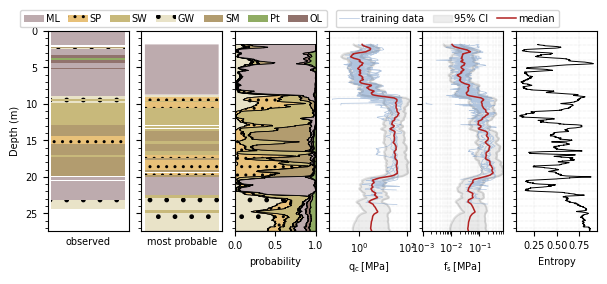

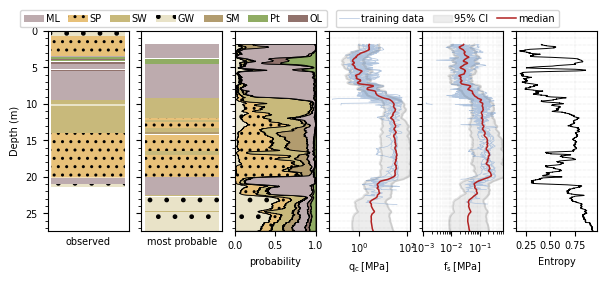

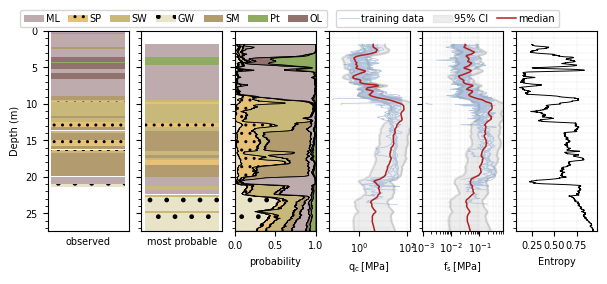

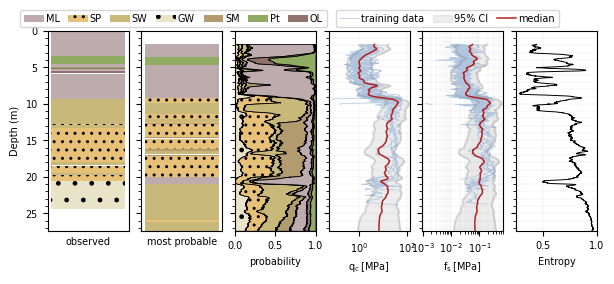

In [27]:
# =============================================================================
# Plots
# =============================================================================
hatches=['.','..','','','','','']
Rn = ['GW', 'SP', 'SW', 'SM', 'ML', 'OL', 'Pt']  # manual ordering accordieng to soil!
indx = []
for i,c in enumerate(Rn):
    indx.append(R.index(c))
    

# lithological plots
# SEE: https://towardsdatascience.com/displaying-lithology-data-using-python-and-matplotlib-58b4d251ee7a

lithology_colors = [(0.9137254901960784, 0.8895686274509804, 0.7843921568627451),      
          (0.9090, 0.75640, 0.4750),              
          (0.7843137254901961, 0.7239215686274509, 0.4835294117647059),
          (0.6980392156862745, 0.6134901960784314, 0.4369411764705882),
          (0.7411764705882353, 0.6687058823529413, 0.6831764705882354),
          (0.5686274509803921, 0.4478431372549019, 0.4219607843137255), 
          (0.5660, 0.6740, 0.3880)]


lithology_numbers = {'ML': {'name':'ML', 'lith_num':1, 'hatch': hatches[Rn.index("ML")], 'color':lithology_colors[Rn.index("ML")]},
                 'SP': {'name':'SP', 'lith_num':2, 'hatch': hatches[Rn.index("SP")], 'color':lithology_colors[Rn.index("SP")]},
                 'SW': {'name':'SW', 'lith_num':3, 'hatch': hatches[Rn.index("SW")], 'color':lithology_colors[Rn.index("SW")]},
                 'GW': {'name':'GW', 'lith_num':4, 'hatch':hatches[Rn.index("GW")], 'color':lithology_colors[Rn.index("GW")]},
                 'SM': {'name':'SM', 'lith_num':5, 'hatch':hatches[Rn.index("SM")], 'color':lithology_colors[Rn.index("SM")]},             
                 'Pt': {'name':'Pt', 'lith_num':11, 'hatch':hatches[Rn.index("Pt")], 'color':lithology_colors[Rn.index("Pt")]},
                 'OL': {'name':'OL', 'lith_num':12, 'hatch':hatches[Rn.index("OL")], 'color':lithology_colors[Rn.index("OL")]}}


# ==============================================================================
# Grid plot with most relevant profiles
# =============================================================================

bhs = ["bh9", "bh1", "bh5", "bh3"]
                            
for loc in range(len(bhs)):      
    Pr_uscs = probabilities[loc].detach().T[indx]

    df = pd.DataFrame(data=max_probs[loc], columns = ["prob"])
    df["class"] =  most_prob_profile[loc]
    df["z"] = np.round(depth, 2)
    df["x"] = 2
    df["H_uscs"] = H[loc]
    df['class'] = df['class'].map(inv_map)                                      
                                          
    fig = plt.figure(figsize = ((15.11+2.9)/2.54, 6.6/2.54))
    gs = fig.add_gridspec(1, 6, hspace=0, wspace=0.155)
    (ax1, ax2, ax3, ax4, ax5, ax6) = gs.subplots(sharex='col', sharey='row')
    # fig.suptitle('Sharing x per column, y per row')
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax2.fill_betweenx(df['z'], 0, 1, where=(df['class']==key),
                              facecolor=color, hatch=hatch, label=key)
    
    # ax1.invert_yaxis()   
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax1.fill_betweenx(df_test["z"], 0, 1, where=(df_test.iloc[:,loc]==key),
                             facecolor=color, hatch=hatch, label=key)
        
    polys = ax3.stackplot(df['z'], Pr_uscs,
                 labels=Rn,edgecolors="black", colors = lithology_colors, linewidth=0.6)
    xlims = ax3.get_xlim()
    xlims = (0, depth_max)
    ylims = ax3.get_ylim()
    for poly in polys:
        for path in poly.get_paths():
            path.vertices = path.vertices[:, ::-1]
            
    for stack, hatch in zip(polys, hatches):
        stack.set_hatch(hatch)

    ax3.set_xlim(ylims)  # use old y limits
    ax3.set_ylim(xlims[::-1])  # use old x limits, reversed

    # -----------------------------------------------------------------------------------------------------------
    for i, dat in enumerate(data_qc.T):
        if i==0:
            ax4.semilogx(np.exp(data_qc[:, i]), (zt*(Dz-1.86)+1.86), '-', color = "lightsteelblue", 
                     linewidth = 0.5, label="training data")
        else:
            ax4.semilogx(np.exp(data_qc[:, i]), (zt*(Dz-1.86)+1.86), '-', color = "lightsteelblue", 
                     linewidth = 0.5)
            

    ax4.semilogx(lower_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.semilogx(upper_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.fill_betweenx(df['z'], 
                      lower_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      upper_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      color = "darkgrey", alpha = 0.2, label='95% CI')
            
    ax4.semilogx(post_median_qc.exp()[loc*nv_test:nv_test*(loc+1)], 
            df['z'], 
            '-', color='firebrick', linewidth = 1.1, label='median')      
    # -----------------------------------------------------------------------------------------------------------

    for i, dat in enumerate(data_fs.T):
        ax5.semilogx(np.exp(data_fs[:, i]), (zt*(Dz-1.86)+1.86), '-', color = "lightsteelblue", linewidth = 0.5)
        
    ax5.semilogx(lower_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax5.semilogx(upper_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax5.fill_betweenx(df['z'], 
                      lower_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      upper_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      color = "darkgrey", alpha = 0.2, label='95% CI')   

    ax5.semilogx(post_median_fs.exp()[loc*nv_test:nv_test*(loc+1)], 
            df['z'], 
            '-', color='firebrick', linewidth = 1.1, label='median')  

    # -----------------------------------------------------------------------------------------------------------

    ax6.plot(H[loc], df['z'], color = "black",linewidth = 0.7)
    # -----------------------------------------------------------------------------------------------------------

    ax5.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.35,linestyle=":")
    ax4.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.35,linestyle=":")
    ax6.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.35,linestyle=":")
    
    ax3.set_xlim(0,1)
    ax5.set_xlim(0,0.7)
    ax4.set_xlim(0,125)

    ax4.set_xlabel(r'$q_c\:[MPa]$ ')
    ax5.set_xlabel(r'$f_s\:[MPa]$ ')

    ax1.set_xlabel("observed")
    ax1.set_ylabel("Depth (m)")
    ax2.set_xlabel("most probable")
    ax3.set_xlabel("probability")
    ax6.set_xlabel("Entropy")
    
    ax5.invert_yaxis() 
    ax6.invert_yaxis() 
    ax4.invert_yaxis() 
    ax3.invert_yaxis() 
    ax2.invert_yaxis() 
    ax1.invert_yaxis() 
    ax2.set_xticks([])  
    ax1.set_xticks([])  
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax4.legend(bbox_to_anchor=(2.90, 1.13), ncol=4, fontsize = 7, handletextpad=0.2, columnspacing=0.9)
    ax1.legend(bbox_to_anchor=(3.50, 1.13), ncol = num_classes, fontsize = 7,handletextpad=0.2, columnspacing=0.9)

    fig.show()    
    
for i in range(2):
    print(model.covar_module.base_kernel.kernels[i].lengthscale.cpu().detach() )


In [28]:
encoded_classes = np.array(encoded_classes, dtype = float)
encoded_classes[encoded_classes == np.max(encoded_classes)] = np.nan


test_classes_bh_num = encoded_classes[:, [8, 0, 4, 2]]
y_test = test_classes_bh_num.T.ravel()
y_test = y_test[~np.isnan(y_test)]
y_vec_test = y_test.astype(int)
y_discrete_test = torch.tensor(y_vec_test).long()
classes_test = np.unique(y_vec_test)
num_classes = len(classes)
Y_test = np.zeros((len(y_vec_test), len(classes_test)))
#Y_pred = np.zeros((len(y_vec_test), len(classes_test)))

for i, e in enumerate(y_vec_test):
    # print(i, e)
    Y_test[i, np.where(classes_test == e)[0]] = 1
    #Y_pred[i, np.where(classes_test == e)[0]] = 1

In [29]:
def cross_entropy(targets, predictions,  epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

test_loc 0
cross entropy 1.244872742905586

accuracy score:  0.6095617529880478

precision score:  0.6442299737097097
------------------------------------
test_loc 1
cross entropy 1.370181483520178

accuracy score:  0.7478305257784584

precision score:  0.7499226101615353
------------------------------------
test_loc 2
cross entropy 1.0263027161756089

accuracy score:  0.6523736600306279

precision score:  0.6616243924514875
------------------------------------
test_loc 3
cross entropy 1.3603554028047178

accuracy score:  0.5865427180168216

precision score:  0.5187613156579157
------------------------------------

accuracy score total:  0.645448079658606

precision score total:  0.662238745651033
cross entropy total 1.2541397496874849


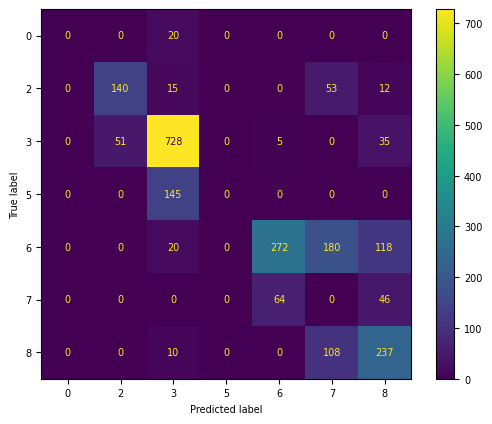

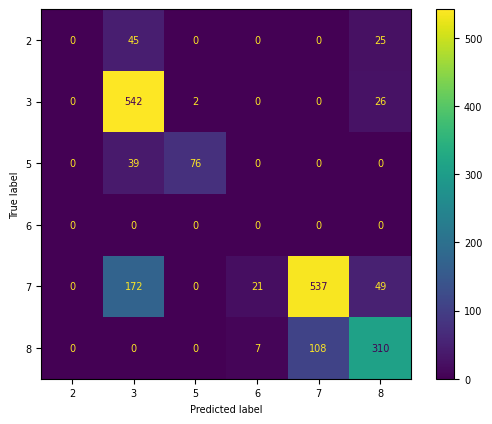

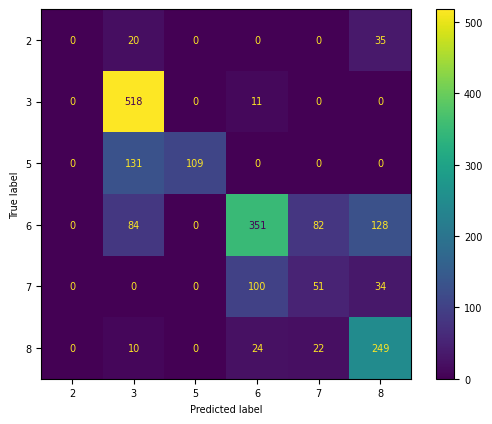

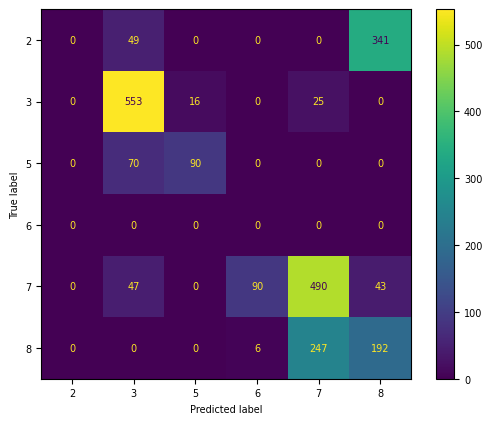

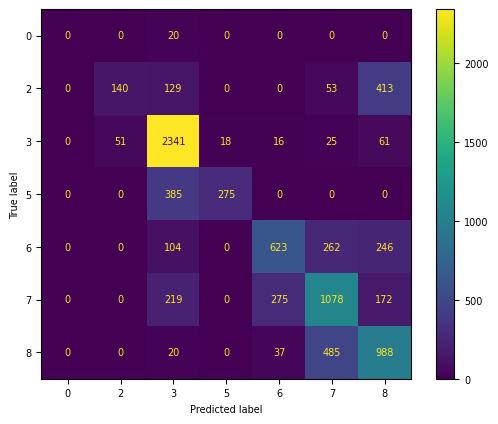

In [30]:
# The number of nonnan elements in each testing borehole
bhi_test_num_el = (np.ones(4)*len(encoded_classes) - np.isnan(encoded_classes[:, [8, 0, 4, 2]]).sum(axis=0)).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, roc_auc_score, log_loss



from collections import defaultdict
dict_metrics_bh = {i: defaultdict(list) for i in range(len(bhs))}

y_true=[]; y_pred=[]; targets = []; inputs = []#to test entire set of bhs
for loc in range(len(bhs)):   

    z_bh = df_test["z"][:bhi_test_num_el[loc]]
    dict_metrics_bh[loc]["z_bh"]=(df_test["z"][:bhi_test_num_el[loc]])
    dict_metrics_bh[loc]["y_test_bh"]=( torch.tensor(Y_test[:bhi_test_num_el[loc], :][np.where(z_bh>=1.86)] ))

    dict_metrics_bh[loc]["y_test_bh_cat"]=np.array(encoded_classes[:, [8, 0, 4, 2]][np.where(z_bh>=1.86)] [:, loc], dtype=int)
   
#     #===========================================
#     #merge OL and Pt (only for predictions)
    dict_metrics_bh[loc]["y_test_bh_cat"][dict_metrics_bh[loc]["y_test_bh_cat"]==4] = 5
#     #===========================================
    pred_probs_bh =  probabilities[loc][np.where(depth<=max(z_bh))]
    z_bh = z_bh[z_bh>=1.86] # disregard the upper 1.86m

    #dict_metrics_bh[loc]["pred_probs_bh"] = probabilities[loc][np.where(depth<=max(z_bh))]
    pred_probs_bh = torch.cat([torch.zeros(len(pred_probs_bh), 2), pred_probs_bh], -1).clone().detach().requires_grad_(True)
    pred_class = np.array(most_prob_profile[loc][np.where(depth<=max(z_bh))],dtype=int)
    dict_metrics_bh[loc]["pred_probs_bh"] = pred_probs_bh
    dict_metrics_bh[loc]["pred_class_bh"] = pred_class

    input = dict_metrics_bh[loc]["pred_probs_bh"]
    target = dict_metrics_bh[loc]["y_test_bh"]
    
    print("test_loc", loc)

    targets.append(target.numpy()); inputs.append(input.detach())
    print("cross entropy", log_loss( target.numpy(), input.detach().numpy()))
    #print("cross entropy manual", cross_entropy( target.numpy(), input.detach().numpy()))
    
    print("\naccuracy score: ",  accuracy_score(dict_metrics_bh[loc]["y_test_bh_cat"], 
                                                     dict_metrics_bh[loc]["pred_class_bh"]))
    
    print("\nprecision score: ",  precision_score(dict_metrics_bh[loc]["y_test_bh_cat"], 
                                                     dict_metrics_bh[loc]["pred_class_bh"], average = "weighted", zero_division = 0.0 ))
    
    ConfusionMatrixDisplay.from_predictions(dict_metrics_bh[loc]["y_test_bh_cat"],
                                            dict_metrics_bh[loc]["pred_class_bh"],
                                           #display_labels=np.sort(pd.Series(dict_metrics_bh[loc]["y_test_bh_cat"]).map(inv_map).unique().tolist())     
                                           )
    
    print("------------------------------------")
    y_true.append(dict_metrics_bh[loc]["y_test_bh_cat"])
    y_pred.append(dict_metrics_bh[loc]["pred_class_bh"])


    
print("\naccuracy score total: ",  accuracy_score(np.concatenate(y_true), 
                                                    np.concatenate(y_pred)
                                                  ))
print("\nprecision score total: ",  precision_score(np.concatenate(y_true), 
                                                    np.concatenate(y_pred), 
                                                  average = "weighted", zero_division = 0.0 ))


print("cross entropy total", log_loss( np.concatenate(targets), np.concatenate(inputs)))


ConfusionMatrixDisplay.from_predictions(np.concatenate(y_true),
                                        np.concatenate(y_pred),
                                        #display_labels=np.sort(pd.Series(dict_metrics_bh[loc]["y_test_bh_cat"]).map(inv_map).unique().tolist())     
                                        )

In [31]:
# Predictions at the test CPT locations
Dz = np.max(z_mat) 

x_p_m = np.array(xt_test)
y_p_m = np.array(yt_test)
nv_test = 2745 - int(1.86/0.01) + 1


zt_test = zt
nv_test = len(zt_test)

nh_test = (x_p_m).shape[0]
n_uscs_samples = 400

z_t = zt_test

x_t = x_p_m
y_t = y_p_m

n_v = (z_t).shape[0]
n_h = (x_t).shape[0]

N = n_v * n_h


grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]


test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).squeeze().t().to(train_X)

In [32]:
def compute_Isbt(qc, fs):
    Rf = fs / qc * 100
    #return ((3.47-np.log10(qc/0.1))**2 + (np.log10(Rf + 1.22)**2))**0.5
    return torch.sqrt((3.47 - torch.log10(qc/0.1))**2 +
                       (1.22 + torch.log10(Rf))**2)
def compute_Rf(qc, fs):
    return fs / qc * 100
    #return ((3.47-np.log10(qc/0.1))**2 + (np.log10(Rf + 1.22)**2))**0.5
    # return np.sqrt((3.47 - np.log10(qc/0.1))**2 +
    #                    (1.22 + np.log10(Rf))**2)


In [33]:
test_dataset = TensorDataset(test_x, test_x)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

model.eval()
likelihood.eval()

means = []; lower = []; upper = [] ; q10 = []; q90 = []; std_batch = []
probs_batched = []; mean_Ic = []; std_Ic = []; samples_Ic_batch = []
#pred_samples_batched = []
with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False,  solves=False),\
    gpytorch.settings.use_toeplitz(False):
        for x_batch_t,_ in test_loader:
            num = len(torch.unique(x_batch_t[:,0]))
            predictions = likelihood(model(x_batch_t))
            means.append(predictions.mean.cpu())
            l, u = predictions.confidence_region()
            lower.append(l)
            upper.append(u)
            std = predictions.variance.sqrt()
            std_batch.append(predictions.variance.sqrt())
  
            quantile_qc_10 = predictions.mean - 1.96*std
            quantile_qc_90 = predictions.mean + 1.96*std

            q10.append(quantile_qc_10)
            q90.append(quantile_qc_90)

            samples = predictions.sample(torch.Size((3000,)))
            pred_samples_uscs = samples.exp()[:,..., :len(classes)]  
            probs_batched.append((pred_samples_uscs / pred_samples_uscs.sum(-1, keepdim=True)).mean(0))

            # compute Ic from samples
            samples_fs = samples[:, ..., -1] * std_fs_log + mu_fs_log
            samples_qc = samples[:, ..., -2] * std_qc_log + mu_qc_log 

            samples_Ic_batch.append(compute_Isbt(samples_qc.exp(), samples_fs.exp()))    


C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


In [34]:
mean = torch.concat([means[i] for i in range(len(means))], dim=0)
lower = torch.concat([lower[i] for i in range(len(lower))], dim=0)
upper = torch.concat([upper[i] for i in range(len(upper))], dim=0)
stdev = torch.concat([std_batch[i] for i in range(len(std_batch))], dim=0)
samples_Ic = torch.concat([samples_Ic_batch[i].T for i in range(len(samples_Ic_batch))], dim=0)

upper_Ic = torch.quantile(samples_Ic, 0.025, dim=1, keepdim=True).squeeze().cpu()
lower_Ic = torch.quantile(samples_Ic, 0.975, dim=1, keepdim=True).squeeze().cpu()
mean_Ic = torch.quantile(samples_Ic, 0.5, dim=1, keepdim=True).squeeze().cpu()

In [35]:
probabilities = torch.cat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)].reshape(nh_test,nv_test,num_classes).cpu()
post_median_qc = (mean[..., -2].cpu()  * std_qc_log + mu_qc_log)   
post_median_fs = (mean[..., -1].cpu()  * std_fs_log + mu_fs_log)   

lower_qc = lower[..., -2].cpu() * std_qc_log + mu_qc_log        
upper_qc = upper[..., -2].cpu() * std_qc_log + mu_qc_log  

lower_fs = lower[..., -1].cpu() * std_fs_log + mu_fs_log        
upper_fs = upper[..., -1].cpu() * std_fs_log + mu_fs_log 


In [36]:
most_prob_profile = np.empty((nh_test, nv_test))
max_probs = np.empty((nh_test, nv_test))
H = np.empty((nh_test, nv_test))

for i, probs in enumerate(probabilities):
    most_prob_profile[i], max_probs[i], H[i] = most_probable_uscs(probs, mapping, inv_map)

In [37]:
def compute_Isbt(qc, fs):
    Rf = fs / qc * 100
    #return ((3.47-np.log10(qc/0.1))**2 + (np.log10(Rf + 1.22)**2))**0.5
    return np.sqrt((3.47 - np.log10(qc/0.1))**2 +
                       (1.22 + np.log10(Rf))**2)
def compute_Rf(qc, fs):
    return fs / qc * 100

C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\304590494.py:162: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\304590494.py:162: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\304590494.py:162: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\304590494.py:162: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6836\304590494.py:162: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


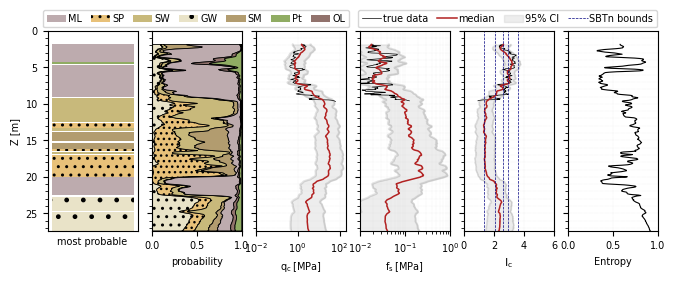

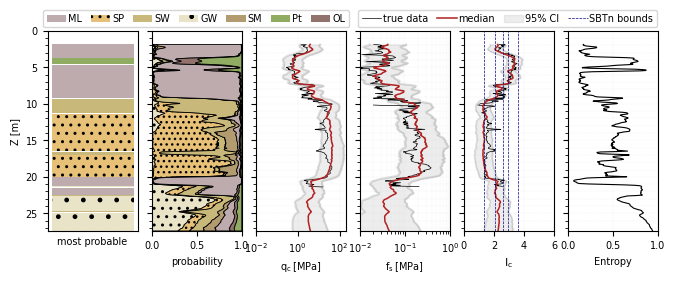

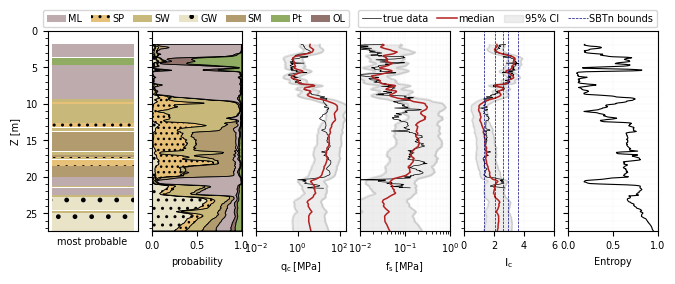

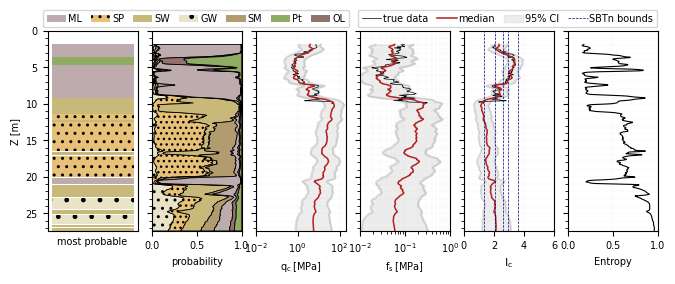

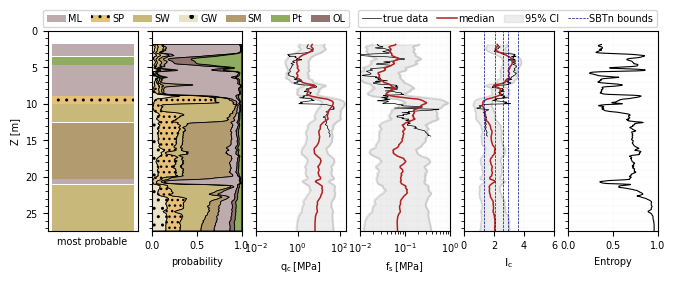

In [38]:
# ==============================================================================
# Grid plot with most relevant profiles
# =============================================================================
task_names = [r'$q_c$']


depth = z_t * (Dz-depth_0) + depth_0       
cpt_locs = ["CPT_2", "CPT_11", "CPT_18", "CPT_13", "CPT_14"]   # with respect to x (see excel file)

hatches=['..','...','','','','','']
Rn = ['GW', 'SP', 'SW', 'SM', 'ML', 'OL', 'Pt']  # manual ordering accordieng to soil!
indx = []
for i,c in enumerate(Rn):
    indx.append(R.index(c))

for loc in range(len(cpt_locs)):      
    Pr_uscs = probabilities[loc].detach().T[indx]

    df = pd.DataFrame(data=max_probs[loc], columns = ["prob"])
    df["class"] =  most_prob_profile[loc]
    df["z"] = np.round(depth, 2)
    df["x"] = 2
    df["H_uscs"] = H[loc]
    df['class'] = df['class'].map(inv_map)                                      
                                          
    fig = plt.figure(figsize = ((15.11+4.9)/2.54, 6.6/2.54))

    #fig = plt.figure(figsize = (16.5/2.54, 2.1))
    gs = fig.add_gridspec(1, 6, hspace=0, wspace=0.155)
    (ax1, ax2, ax3, ax4, ax5, ax6) = gs.subplots(sharex='col', sharey='row')
    # fig.suptitle('Sharing x per column, y per row')
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax1.fill_betweenx(df['z'], 0, 1, where=(df['class']==key),
                              facecolor=color, hatch=hatch, label=key)
    
        
    polys = ax2.stackplot(df['z'], Pr_uscs,
                 labels=Rn,edgecolors="black", colors = lithology_colors, linewidth=0.6)
    xlims = ax2.get_xlim()
    xlims = (0, depth_max)
    ylims = ax2.get_ylim()
    for poly in polys:
        for path in poly.get_paths():
            path.vertices = path.vertices[:, ::-1]
            
    for stack, hatch in zip(polys, hatches):
        stack.set_hatch(hatch)

    ax3.set_xlim(ylims)  # use old y limits
    ax3.set_ylim(xlims[::-1])  # use old x limits, reversed

    # -----------------------------------------------------------------------------------------------------------
    # for i, dat in enumerate(data_qc_test.T):
    #     if i==0:
    ax3.semilogx(np.exp(data_qc_test[:, loc]), depth, '-', color='black', linewidth = 0.5, label='true data')
        # else:
        #     ax3.semilogx(np.exp(data_qc_test[:, i]), depth, '-', color = "lightsteelblue", 
        #             , linewidth = 1.2)
            

    ax3.semilogx(lower_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax3.semilogx(upper_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax3.fill_betweenx(df['z'], 
                      lower_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      upper_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      color = "darkgrey", alpha = 0.2, label='95% CI')
            
    ax3.plot(post_median_qc.exp()[loc*nv_test:nv_test*(loc+1)], 
            df['z'], 
            '-', color='firebrick', linewidth = 1.1, label='median')      
    # -----------------------------------------------------------------------------------------------------------
    
    #for i, dat in enumerate(data_qc_test.T):
    ax4.semilogx(np.exp(data_fs_test[:, loc]), depth, '-', color='black', linewidth = 0.5, label='true data')
        
    ax4.semilogx(lower_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.semilogx(upper_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.fill_betweenx(df['z'], 
                      lower_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      upper_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      color = "darkgrey", alpha = 0.2, label='95% CI')   

    ax4.plot(post_median_fs.exp()[loc*nv_test:nv_test*(loc+1)], 
            df['z'], 
            '-', color='firebrick', linewidth = 1.1, label='median')  

    # -----------------------------------------------------------------------------------------------------------

    data_Ic_test = compute_Isbt(np.exp(data_qc_test[:, loc]), np.exp(data_fs_test[:, loc]))
    ax5.plot(data_Ic_test, 
            depth, '-', color='black', linewidth = 0.5, label='true data')
    ax5.plot(mean_Ic[loc*nv_test:nv_test*(loc+1)], 
            df['z'], '-', color='firebrick', linewidth = 1.1, label="median")
    
    

    
    # Shade in confidence
    ax5.fill_betweenx( depth, upper_Ic.squeeze()[loc*nv_test:nv_test*(loc+1)], 
    lower_Ic.squeeze()[loc*nv_test:nv_test*(loc+1)], 
    color = "darkgrey", alpha = 0.2 , label='95% CI')     

    ax5.plot(upper_Ic.squeeze()[loc*nv_test:nv_test*(loc+1)],(depth), 
                      color = "black", linewidth = 1, alpha = 0.1)
    ax5.plot(lower_Ic.squeeze()[loc*nv_test:nv_test*(loc+1)],(depth), 
                      color = "black", linewidth = 1, alpha = 0.1)
    
    for xc in bounds:
        if xc == bounds[0]:
            ax5.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5, label = "SBTn bounds")
        else:
            ax5.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5)
    # -----------------------------------------------------------------------------------------------------------
    ax6.plot(H[loc], df['z'],linewidth = 0.8, color = "black")
    # -----------------------------------------------------------------------------------------------------------

    ax5.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.15,linestyle=":")
    ax4.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.15,linestyle=":")
    ax3.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.15,linestyle=":")
    ax6.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.15,linestyle=":")
    
    ax5.set_xlim(0,6)
    ax2.set_xlim(0,1)
    #ax4.set_xlim(0,0.7)
    ax3.set_xlim(0.01,200)
    ax4.set_xlim(0.01,1)
    ax6.set_xlim(0,1)
    
    ax3.set_xlabel(r'$q_c\:[MPa]$ ')
    ax4.set_xlabel(r'$f_s\:[MPa]$ ')
    ax5.set_xlabel(r'$I_c$ ',fontsize=8)
    ax5.legend(bbox_to_anchor=(2.20, 1.13), ncol=4, fontsize = 7, handletextpad=0.2, columnspacing=0.9)

    ax1.set_xlabel("most probable")
    ax1.set_ylabel("Z [m]")
    ax2.set_xlabel("probability")
    ax6.set_xlabel("Entropy")
    
     
    ax6.invert_yaxis() 
    ax5.invert_yaxis() 
    ax4.invert_yaxis() 
    ax3.invert_yaxis() 
    ax2.invert_yaxis()
    ax1.invert_yaxis() 
    ax1.set_xticks([])  
    ax1.set_xticks([])  
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.legend(bbox_to_anchor=(3.40, 1.13), ncol = num_classes, fontsize = 7,handletextpad=0.2, columnspacing=0.9)
    fig.show()    